E:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TEST_MODE is ON – running in test mode (reduced data, fewer trials).


[I 2025-06-29 13:01:46,102] A new study created in memory with name: no-name-a2ee6893-6b65-4a4a-8166-61cbdc2d3c3f


[I 2025-06-29 13:02:20,787] Trial 0 finished with value: 94229.21405396209 and parameters: {'iterations': 501, 'depth': 10, 'learning_rate': 0.16349995250719132, 'l2_leaf_reg': 5.119973134332332, 'bagging_temperature': 0.5118131338418502, 'random_strength': 0.7560980467753534}. Best is trial 0 with value: 94229.21405396209.


[I 2025-06-29 13:02:28,352] Trial 1 finished with value: 93927.39861013899 and parameters: {'iterations': 486, 'depth': 6, 'learning_rate': 0.16962782145466393, 'l2_leaf_reg': 0.06532615700492027, 'bagging_temperature': 0.25226150555951476, 'random_strength': 0.25790614900986286}. Best is trial 1 with value: 93927.39861013899.


[I 2025-06-29 13:02:42,390] Trial 2 finished with value: 93200.2362791345 and parameters: {'iterations': 900, 'depth': 6, 'learning_rate': 0.1975242264083435, 'l2_leaf_reg': 0.20491349223657934, 'bagging_temperature': 0.7120049248151089, 'random_strength': 0.5782863252845571}. Best is trial 2 with value: 93200.2362791345.


[I 2025-06-29 13:02:45,461] A new study created in memory with name: no-name-186c8f8c-5a6b-49ec-93bb-2ab8af51b55d


[I 2025-06-29 13:02:53,256] Trial 0 finished with value: 98006.7451106444 and parameters: {'iterations': 673, 'depth': 4, 'learning_rate': 0.07619479168438804, 'l2_leaf_reg': 0.004179853590947606, 'bagging_temperature': 0.8011367914083377, 'random_strength': 0.2738280181268393}. Best is trial 0 with value: 98006.7451106444.


[I 2025-06-29 13:03:01,057] Trial 1 finished with value: 96354.93227465903 and parameters: {'iterations': 609, 'depth': 5, 'learning_rate': 0.24154841165921542, 'l2_leaf_reg': 0.02043508691997735, 'bagging_temperature': 0.8974564173029169, 'random_strength': 0.23020257262673427}. Best is trial 1 with value: 96354.93227465903.


[I 2025-06-29 13:03:17,289] Trial 2 finished with value: 94666.61620270977 and parameters: {'iterations': 689, 'depth': 8, 'learning_rate': 0.08913996226342394, 'l2_leaf_reg': 1.0632299148326063, 'bagging_temperature': 0.6192288901963037, 'random_strength': 0.8745240326018785}. Best is trial 2 with value: 94666.61620270977.


Evaluation – CatBoost + Optuna CV (All Features)
  MAE:  37,995.89 €
  RMSE: 52,421.06 €
  R²:   0.9370
----------------------------------------
Evaluation – CatBoost + Optuna CV (Top RF Features)
  MAE:  45,114.43 €
  RMSE: 63,212.98 €
  R²:   0.9085
----------------------------------------
[✓] Model evaluation for 'CatBoost + Optuna CV (All Features)' logged.
[✓] Model evaluation for 'CatBoost + Optuna CV (Top RF Features)' logged.
Evaluation Summary (All Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,109,2025-06-29 13:00:02,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,Linear Regression (All Features),202506291259,76 898.76 €,109 935.46 €,0.723000,Linear,6,1.430000,
1,110,2025-06-29 13:00:29,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,Random Forest (All Features),202506291259,68 324.02 €,101 428.25 €,0.764200,Tree,4,1.480000,
2,111,2025-06-29 13:00:38,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,Random Forest (Top 10 Features),202506291259,71 734.61 €,106 140.03 €,0.741800,Tree,5,1.480000,
3,112,2025-06-29 13:01:33,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,XGBoost with Optuna (All Features) [TEST],202506291259,56 908.05 €,81 725.97 €,0.847000,Boosting,3,1.440000,
4,113,2025-06-29 13:01:33,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291259,5 009.87 €,8 972.41 €,0.998200,Boosting,1,1.790000,✓
5,114,2025-06-29 13:03:20,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,CatBoost with Optuna (All Features),202506291259,37 995.89 €,52 421.06 €,0.937000,Boosting,2,1.380000,



👉 Best model based on R²: XGBoost + Optuna CV (Top RF Features) [TEST] ✓
Evaluation Summary (Top RF Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,109,2025-06-29 13:00:02,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,Linear Regression (All Features),202506291259,76 898.76 €,109 935.46 €,0.723000,Linear,7,1.430000,
1,110,2025-06-29 13:00:29,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,Random Forest (All Features),202506291259,68 324.02 €,101 428.25 €,0.764200,Tree,5,1.480000,
2,111,2025-06-29 13:00:38,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,Random Forest (Top 10 Features),202506291259,71 734.61 €,106 140.03 €,0.741800,Tree,6,1.480000,
3,112,2025-06-29 13:01:33,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,XGBoost with Optuna (All Features) [TEST],202506291259,56 908.05 €,81 725.97 €,0.847000,Boosting,4,1.440000,
4,113,2025-06-29 13:01:33,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291259,5 009.87 €,8 972.41 €,0.998200,Boosting,1,1.790000,✓
5,114,2025-06-29 13:03:20,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,CatBoost with Optuna (All Features),202506291259,37 995.89 €,52 421.06 €,0.937000,Boosting,2,1.380000,
6,115,2025-06-29 13:03:20,CatBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_1259.csv,CatBoost with Optuna (Top RF Features),202506291259,45 114.43 €,63 212.98 €,0.908500,Boosting,3,1.400000,



👉 Best model based on R²: XGBoost + Optuna CV (Top RF Features) [TEST] ✓
Diagnostics (All Features):


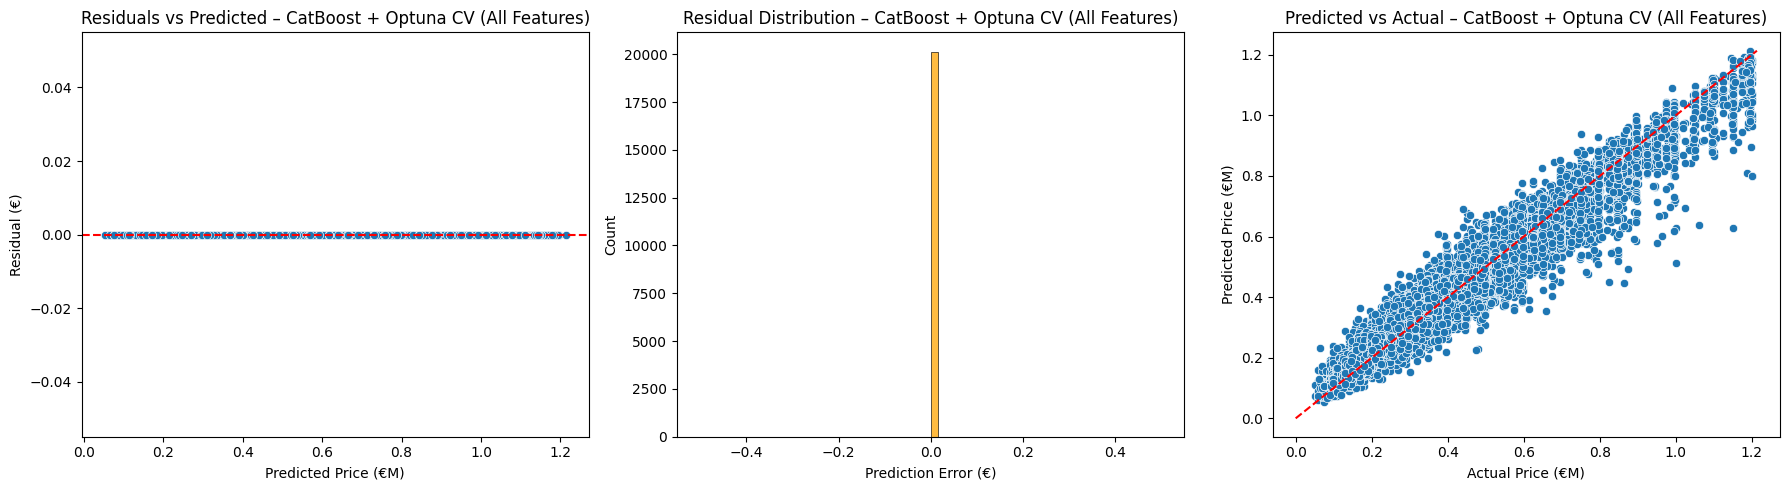

Diagnostics (Top RF Features):


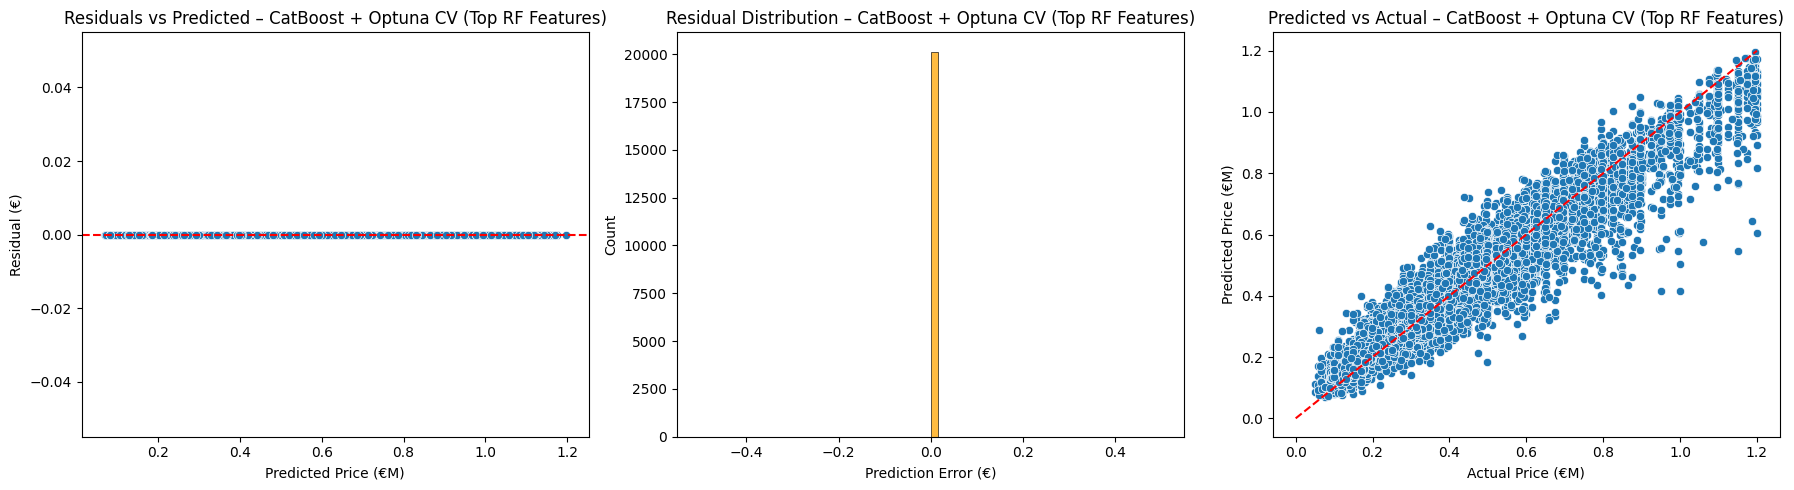

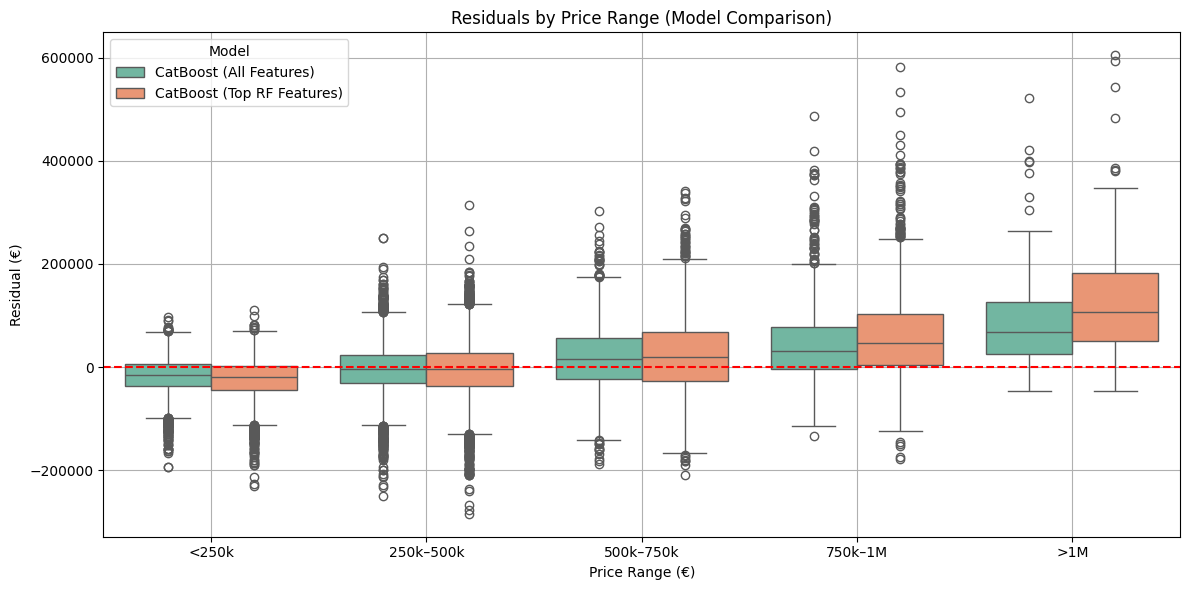

'\nModelEvaluator.plot_shap_comparison_beeswarm(\n    model_all=model_all,\n    x_all=X_reduced,\n    model_top=model_top,\n    x_top=X_top\n)\n'

In [1]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.experiment_tracker import ExperimentTracker
from utils.model_visualizer import ModelVisualizer


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


if TEST_MODE:
    print("TEST_MODE is ON – running in test mode (reduced data, fewer trials).")
else:
    print("TEST_MODE is OFF – full training is active.")


# Step 1: Load and clean dataset
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()
X = df.drop(columns=["price"])
y = df["price"]

# Step 2: Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = X.loc[:, selector.fit(X).get_support()]

# Step 3: Extract top 30 features using Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_reduced, y)
top_features = pd.Series(rf_model.feature_importances_, index=X_reduced.columns).nlargest(30).index.tolist()
X_top = X_reduced[top_features]

# Step 4: Define Optuna objective for CatBoost
def tune_catboost_with_optuna(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 300, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
        }

        model = CatBoostRegressor(
            **params,
            verbose=0,
            loss_function="RMSE",
            random_state=42
        )

        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in cv.split(X_data):
            X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
            y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]

            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            scores.append(root_mean_squared_error(y_val, preds))
        return np.mean(scores)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study

# Step 5: Tune and train both models
n_trials = 3 if TEST_MODE else 50

# All Features
study_all = tune_catboost_with_optuna(X_reduced, y, n_trials)
model_all = CatBoostRegressor(**study_all.best_params, verbose=0, loss_function="RMSE", random_state=42)
model_all.fit(X_reduced, y)
y_pred_all = model_all.predict(X_reduced)

# Top RF Features
study_top = tune_catboost_with_optuna(X_top, y, n_trials)
model_top = CatBoostRegressor(**study_top.best_params, verbose=0, loss_function="RMSE", random_state=42)
model_top.fit(X_top, y)
y_pred_top = model_top.predict(X_top)

# Step 6: Evaluation
evaluator_all = ModelEvaluator("CatBoost + Optuna CV (All Features)")
mae_all, rmse_all, r2_all = evaluator_all.evaluate(y, y_pred_all)

evaluator_top = ModelEvaluator("CatBoost + Optuna CV (Top RF Features)")
mae_top, rmse_top, r2_top = evaluator_top.evaluate(y, y_pred_top)

# Step 7: Log results
tracker = ExperimentTracker()
df_metrics_all = tracker.log_and_get_evaluations(
    model="CatBoost + Optuna CV (All Features)",
    experiment="CatBoost with Optuna (All Features)",
    mae=mae_all,
    rmse=rmse_all,
    r2=r2_all,
)

df_metrics_top = tracker.log_and_get_evaluations(
    model="CatBoost + Optuna CV (Top RF Features)",
    experiment="CatBoost with Optuna (Top RF Features)",
    mae=mae_top,
    rmse=rmse_top,
    r2=r2_top,
)

# Step 8: Summary & Diagnostics
print("Evaluation Summary (All Features):")
evaluator_all.display_model_summary(df_metrics_all)

print("Evaluation Summary (Top RF Features):")
evaluator_top.display_model_summary(df_metrics_top)

print("Diagnostics (All Features):")
ModelVisualizer(model_all, X_reduced, y, "CatBoost + Optuna CV (All Features)").plot_all_diagnostics()

print("Diagnostics (Top RF Features):")
ModelVisualizer(model_top, X_top, y, "CatBoost + Optuna CV (Top RF Features)").plot_all_diagnostics()

# Step 9: Residuals & SHAP Comparison
ModelEvaluator.plot_price_range_residuals_side_by_side(
    y, y_pred_all, y_pred_top,
    model_names=("CatBoost (All Features)", "CatBoost (Top RF Features)")
)

"""
ModelEvaluator.plot_shap_comparison_beeswarm(
    model_all=model_all,
    x_all=X_reduced,
    model_top=model_top,
    x_top=X_top
)
"""

In [2]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import joblib
from datetime import datetime
from utils.constants import TEST_MODE, MODELS_DIR

# Create timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Add suffix if in TEST mode
suffix = "_TEST" if TEST_MODE else ""

# Define subdirectory for .pkl files
PKL_DIR = os.path.join(MODELS_DIR, "pkl")
if os.path.isfile(PKL_DIR):
    os.remove(PKL_DIR)  # Remove conflicting file if it exists
os.makedirs(PKL_DIR, exist_ok=True)

# Build filenames
filename_all = f"catboost_optuna_all_{timestamp}{suffix}.pkl"
filename_top = f"catboost_optuna_top30_{timestamp}{suffix}.pkl"

# Save models
joblib.dump(model_all, os.path.join(PKL_DIR, filename_all))
joblib.dump(model_top, os.path.join(PKL_DIR, filename_top))

print(f"[✔] CatBoost models saved to '{PKL_DIR}' as:\n - {filename_all}\n - {filename_top}")


[✔] CatBoost models saved to 'E:\_SoftEng\_BeCode\real-estate-price-predictor\models\pkl' as:
 - catboost_optuna_all_20250629_1303_TEST.pkl
 - catboost_optuna_top30_20250629_1303_TEST.pkl
